# Throughput: Measuring Chat Completion Throughput w/ TPS

# Setup

In [1]:
from random import sample
from time import perf_counter_ns as seed

from jax import random
from matplotlib import pyplot as plt

import llama_jax as ll
from llama_jax.chat import Message

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



W0000 00:00:1741024811.016571 11879713 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1741024811.033466 11879713 service.cc:145] XLA service 0x137b6a3a0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741024811.033477 11879713 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1741024811.034969 11879713 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1741024811.034984 11879713 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


In [2]:
key = random.key(seed())

# Session

In [3]:
system_prompt = ll.tools.prompt(
    """
    You're answering a basic set of questions as part of an LLM test suite.

    - All of your responses should be formatted as markdown.
    - Answer in a single sentence whenever possible or not otherwise instructed.
    - Don't ramble.
    """
)

In [4]:
session = ll.chat.session(system_prompt=system_prompt, warmup_tokens=20)

Warmup (1/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (2/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (3/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (4/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (5/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (6/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (7/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (8/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (9/10):   0%|          | 0/20 [00:00<?, ?it/s]

Warmup (10/10):   0%|          | 0/20 [00:00<?, ?it/s]

# Prompts

In [5]:
prompt_pool = (
    "Why sky is blue?",
    "How stars are formed?",
    "Can animals feel emotions?",
    "What causes economic inflation?",
    "How computers understand language?",
    "Why people dream nightly?",
    "Are aliens actually real?",
    "What defines true intelligence?",
    "How memory actually works?",
    "Why seasons change yearly?",
    "Can AI experience consciousness?",
    "How vaccines protect health?",
    "Why mountains form naturally?",
    "What determines musical talent?",
    "How species become extinct?",
    "Why oceans appear blue?",
    "What causes thunder sounds?",
    "How languages naturally evolve?",
    "Why humans need sleep?",
    "What makes diamonds valuable?"
)

In [6]:
# Verify all messages have same length
values = []
for content in prompt_pool:
    prompt = ll.chat.render_prompt([Message(role="user", content=content)])
    token_ids, position_mask = session.tokenizer.encode(prompt)
    values.append(token_ids.shape[-1])
assert all(v == values[0] for v in values)

# Basic Scenario

In [7]:
data = {}

prompts = sample(prompt_pool, k=3)
prompts

['Why people dream nightly?',
 'Why mountains form naturally?',
 'How languages naturally evolve?']

In [8]:
# Cold
prompt = prompts[0]

key, subkey = random.split(key)
with ll.render.token_view(session.config, prompt) as view:
    for token in ll.chat.complete(session, content=prompt, key=subkey):
        view.add_token(token)
    
    data["cold"] = view.tps

Output()

In [9]:
# p0
prompt = prompts[0]

key, subkey = random.split(key)
with ll.render.token_view(session.config, prompt) as view:
    for token in ll.chat.complete(session, content=prompt, key=subkey):
        view.add_token(token)
    
    data["p0"] = view.tps

Output()

In [10]:
# p1
prompt = prompts[1]

key, subkey = random.split(key)
with ll.render.token_view(session.config, prompt) as view:
    for token in ll.chat.complete(session, content=prompt, key=subkey):
        view.add_token(token)
    
    data["p1"] = view.tps

Output()

In [11]:
# p2
prompt = prompts[2]

key, subkey = random.split(key)
with ll.render.token_view(session.config, prompt) as view:
    for token in ll.chat.complete(session, content=prompt, key=subkey):
        view.add_token(token)
    
    data["p2"] = view.tps

Output()

[Text(0.5, 1.0, 'TPS')]

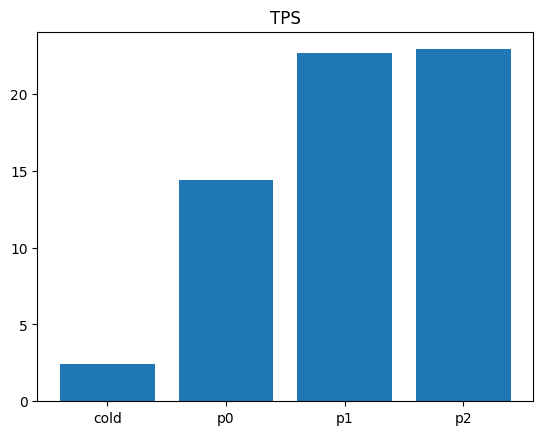

In [12]:
fig, ax = plt.subplots()
ax.bar(data.keys(), data.values())
ax.set(title=f"TPS")